In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
result_gptsniffer = pd.read_csv("./Lucas/unknown_predicted_by_CodeBert.csv")
result_gptsniffer = result_gptsniffer.rename(columns={"predicted_label": "classification"})
result_gptsniffer.drop(columns=["Unnamed: 0", "id", "score", "predicted"], inplace=True)

In [4]:
result_gptsniffer["classification"].value_counts()

classification
human        1706
generated      12
Name: count, dtype: int64

In [34]:
res_rag_1 = pd.read_csv("./data/rag_predictions/prediction_unk_rag_0-151.csv")
res_rag_2 = pd.read_csv("./data/rag_predictions/prediction_unk_rag_150-900.csv")
res_rag_3 = pd.read_csv("./data/rag_predictions/prediction_unk_rag_900-934.csv")
res_rag_4 = pd.read_csv("./data/rag_predictions/prediction_unk_rag_930-full.csv")


result_rag = pd.concat([res_rag_1, res_rag_2, res_rag_3, res_rag_4], ignore_index=True)
result_rag.drop_duplicates(subset=["submission_id"], inplace=True)
result_rag["submission_id"] = result_rag["submission_id"].astype(int)
result_rag.shape

(1718, 7)

In [35]:
submissions = pd.read_csv("./data/submissions.csv")
result_rag = result_rag.merge(submissions[["time", "submission_id"]], on="submission_id", how="left")

In [36]:
result_rag["classification"].value_counts() 

classification
human        1357
generated     361
Name: count, dtype: int64

In [37]:
print(result_rag.shape[0], result_gptsniffer.shape[0])
all_in_gpt = result_rag["submission_id"].isin(result_gptsniffer["submission_id"]).all()
print("All result_rag submission_ids are in result_gpt:", all_in_gpt)
missing_from_rag = result_gptsniffer[~result_gptsniffer["submission_id"].isin(result_rag["submission_id"])]
print("Number of rows in result_gpt not in result_rag:", len(missing_from_rag))

assert len(missing_from_rag) == result_gptsniffer.shape[0] - result_rag.shape[0], "The number of rows in result_gpt not in result_rag does not match the difference in shape."

1718 1718
All result_rag submission_ids are in result_gpt: True
Number of rows in result_gpt not in result_rag: 0


In [38]:
result_gptsniffer["source"] = "gptsniffer"
result_rag["source"] = "rag"
combined = pd.concat([result_gptsniffer, result_rag], ignore_index=True)

In [39]:
result = (
    combined
    .groupby(["problem_id", "classification", "source"])
    .size()  # counts occurrences instead of counting all columns
    .unstack(fill_value=0)
)
result

source                     gptsniffer  rag
problem_id classification                 
05_List_11 generated                9  361
           human                 1295  943
08_Dict_22 generated                3    0
           human                  411  414

In [40]:
import re

def convert_time_to_years(text: str):
    if "year" in text:
        match = re.search(r"(\d+)", text)
        if match:
            num_years = int(match.group(1))
            if "almost" in text:
                return num_years - 0.2  # Slightly before the full year
            elif "over" in text:
                return num_years + 0.2  # Slightly after the full year
            return num_years  # Regular year
    
    elif "month" in text:
        match = re.search(r"(\d+)", text)
        if match:
            num_months = int(match.group(1))
            return round(num_months / 12, 2)  # Convert months to years
    
    elif "day" in text:
        match = re.search(r"(\d+)", text)
        if match:
            num_days = int(match.group(1))
            return round(num_days / 365, 3)  # Convert days to years
    
    elif "hour" in text:
        match = re.search(r"(\d+)", text)
        if match:
            num_hours = int(match.group(1))
            return round(num_hours / 8760, 6)

    return None  # Default case

In [41]:
combined["time_numeric"] = combined["time"].apply(convert_time_to_years)
grouped = (
    combined.groupby(["problem_id", "time_numeric", "source", "classification"])
    .agg(
        time=('time', 'first'),  # Get the 'time' corresponding to each 'time_numeric'
        count=('submission_id', 'size')  # Count submissions in each group
    )
    .unstack(fill_value=0)
    .reset_index()
)

In [42]:
grouped = (
    combined.groupby(["problem_id", "time_numeric", "source", "classification"])
    .size()  # Count the number of occurrences for each group
    .unstack(fill_value=0)  # Unstack to have classification as columns (e.g., 'human', 'generated')
    .reset_index()
)
grouped["time"] = grouped.apply(
    lambda row: combined[(combined["problem_id"] == row["problem_id"]) & 
                         (combined["time_numeric"] == row["time_numeric"])]["time"].iloc[0], 
    axis=1
)

In [43]:
grouped

classification,problem_id,time_numeric,source,generated,human,time
0,05_List_11,0.002511,gptsniffer,0,3,about 22 hours ago
1,05_List_11,0.002511,rag,2,1,about 22 hours ago
2,05_List_11,0.003000,gptsniffer,0,17,1 day ago
3,05_List_11,0.003000,rag,9,8,1 day ago
4,05_List_11,0.005000,gptsniffer,0,9,2 days ago
...,...,...,...,...,...,...
73,08_Dict_22,0.920000,rag,0,17,11 months ago
74,08_Dict_22,1.000000,gptsniffer,0,215,about 1 year ago
75,08_Dict_22,1.000000,rag,0,215,about 1 year ago
76,08_Dict_22,1.200000,gptsniffer,2,157,over 1 year ago


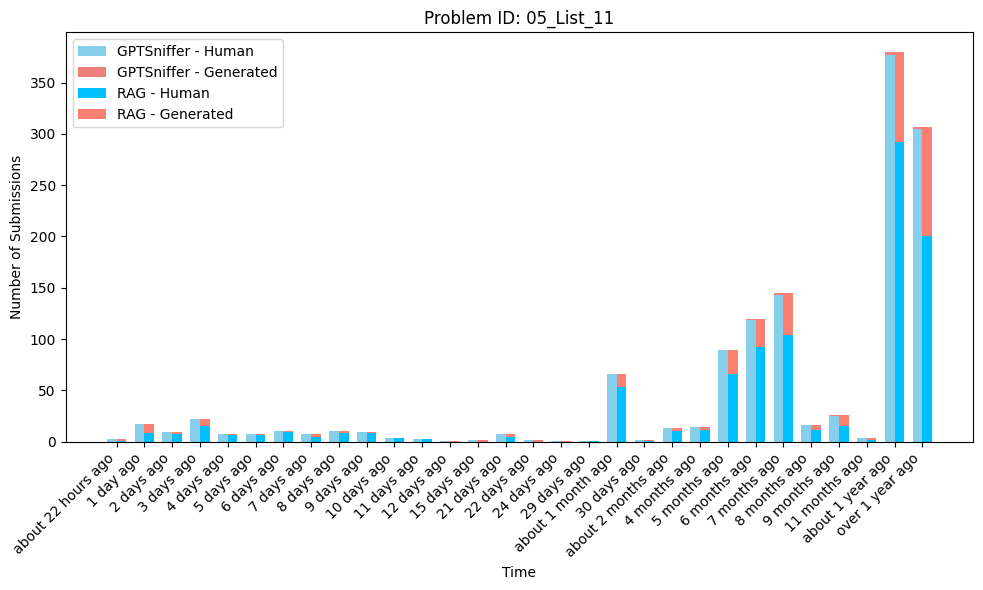

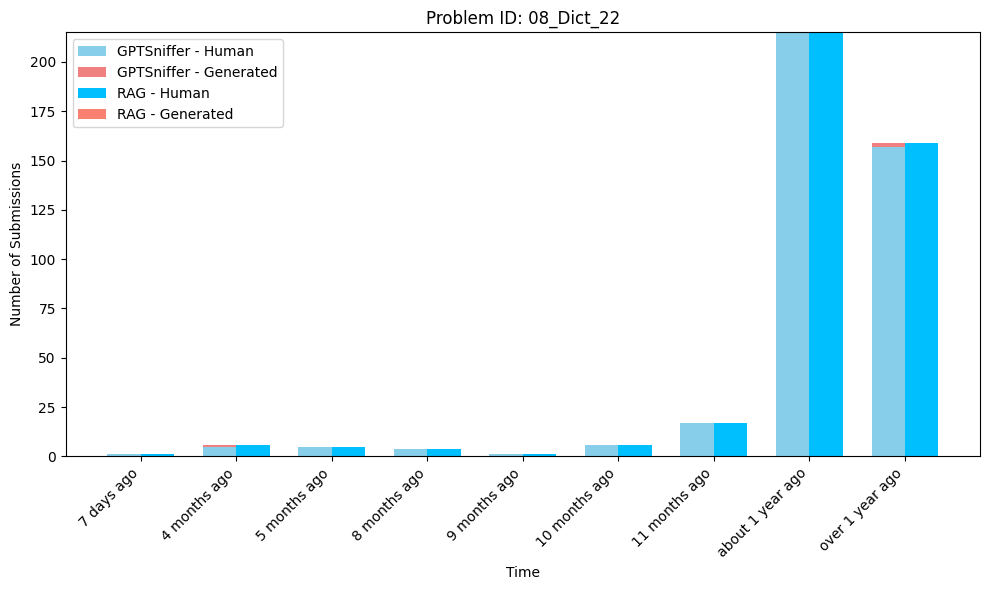

In [44]:
for pid in grouped["problem_id"].unique():
    data = grouped[grouped["problem_id"] == pid]
    data_sorted = data.sort_values("time_numeric")

    gpt = data_sorted[data_sorted["source"] == "gptsniffer"]
    rag = data_sorted[data_sorted["source"] == "rag"]
    
    width = 0.35
    unique_times = data_sorted["time_numeric"].unique()
    x = np.arange(len(unique_times))
    time_to_x = {time: i for i, time in enumerate(unique_times)}

    # Assign x positions
    gpt_x = gpt["time_numeric"].map(time_to_x)
    rag_x = rag["time_numeric"].map(time_to_x)


    fig, ax = plt.subplots(figsize=(10, 6))

    gpt_human = gpt["human"] if "human" in gpt.columns else 0
    gpt_generated = gpt["generated"] if "generated" in gpt.columns else 0

    rag_human = rag["human"] if "human" in rag.columns else 0
    rag_generated = rag["generated"] if "generated" in rag.columns else 0

    ax.bar(gpt_x - width/2, gpt_human, width, label="GPTSniffer - Human", color="skyblue")
    ax.bar(gpt_x - width/2, gpt_generated, width, bottom=gpt_human, label="GPTSniffer - Generated", color="lightcoral")

    ax.bar(rag_x + width/2, rag_human, width, label="RAG - Human", color="deepskyblue")
    ax.bar(rag_x + width/2, rag_generated, width, bottom=rag_human, label="RAG - Generated", color="salmon")


    ax.set_xticks(x)
    xtick_labels = data_sorted.drop_duplicates("time_numeric")["time"].tolist()
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Submissions")
    ax.set_title(f"Problem ID: {pid}")
    ax.legend()

    plt.tight_layout()
    plt.show()